# Drone Radiation Pattern

In [4]:
import pandas as pd
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends import backend_ps
from matplotlib.figure import Figure
from tqdm import tqdm
import struct
import statistics

# Used Functions

In [22]:
def plot_rss(data: pd.DataFrame, time_window = None, color: str = None):
    plt.figure(figsize=(50, 5))
    if (color is not None):
        plt.plot(data['time'], data['rss'], color)
    else:
        plt.plot(data['time'], data['rss'])
    plt.title('RSS of Drone')
    plt.xlabel('Time (s)')
    if (time_window is not None):
        plt.xlim(time_window)
    plt.ylabel('RSS (dB)')
    plt.grid(True)
    plt.show()

In [23]:
def read_binary_iq_samples(filename: str):
    i_values = []
    q_values = []

    with open(filename, 'rb') as file:
        while True:
            # Read 4 bytes (32 bits) from the file
            i = file.read(4)
            if not i:
                break

            q = file.read(4)
            if not 1:
                break

            # Unpack the binary data into a single float
            i = struct.unpack('f', i)[0]
            q = struct.unpack('f', q)[0]

            i_values.append(i)
            q_values.append(q)

    return pd.DataFrame({'i': i_values, 'q': q_values})

In [24]:
def fill_iq_with_rss(samples: pd.DataFrame, time_window: float = None, noise_floor: float = None):
    if (time_window is not None):
        samples['time'] = (samples.index / len(samples)) * 10

    samples['rss'] = samples['i']**2 + samples['q']**2
    samples = samples[samples['rss'] != 0]
    samples.loc[:, 'rss'] = 10*np.log10(samples['rss']) #RSS
    
    samples = samples.replace([np.inf, -np.inf], np.nan)
    samples = samples.dropna(axis = 0, inplace=False)

    samples = samples[samples['rss'] != 0]

    if (noise_floor is not None):
        samples = samples[samples['rss'] >= noise_floor]
    
    return samples


In [25]:
def extract_packets(samples: pd.DataFrame, noise_floor, window: int = 10000):
    samples['rolling_rss'] = samples['rss'].rolling(window=window).median()
    samples = samples[samples['rolling_rss'] >= noise_floor]
    samples = samples[samples['rss'] >= noise_floor]

    return samples

In [26]:
def create_radiation_pattern(ax, data_dict, scale=1, y_limit=None, title=None):
    data_dict = {k: v for k, v in sorted(data_dict.items())}

    #  Extracting the index and value from the dictionary
    indices = list(data_dict.keys())
    values = list(data_dict.values())

    # Scaling the values
    values = [value * scale for value in values]

    # Converting the indices to radians
    angles = np.radians(indices)

    # Adding the first angle at the end to close the plot
    angles = np.append(angles, angles[0])

    # Adding the first value at the end to close the plot
    values = np.append(values, values[0])

    # Creating the round plot
    ax.plot(angles, values, marker='o')

    ax.set_title(title)

    # Setting the labels for each angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(indices)

    # Limiting the y-values if specified
    if y_limit is not None:
        ax.set_ylim(y_limit)

In [27]:
def create_radiation_pattern_tuple(ax, data_dict, scale=1, y_limit=None, title=None, id: list[int] = [0]):
    data_dict = {k: v for k, v in sorted(data_dict.items())}

    #  Extracting the index and value from the dictionary
    indices = list(data_dict.keys())
    values = list(data_dict.values())

    # Scaling the values
    values = [[value * scale for value in val_tuple] for val_tuple in values]

    # Converting the indices to radians
    angles = np.radians(indices)

    # Adding the first angle at the end to close the plot
    angles = np.append(angles, angles[0])

    values.append(values[0])
    
    labels = {0: 'Mean', 1: 'Median', 2: 'QQ60', 3: 'QQ75', 4: 'QQ90', 5: 'QQ95'}

    # Creating the round plot
    for i, vals in enumerate(zip(*values)):
        if (i in id):
            ax.plot(angles, vals, marker='o', label=labels[i])

    ax.set_title(title)

    # Setting the labels for each angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(indices)

    # Limiting the y-values if specified
    if y_limit is not None:
        ax.set_ylim(y_limit)


In [28]:
def create_radiation_pattern_tuple_label(ax, data_dict, scale=1, y_limit=None, title=None, id: list[int] = [0], label: str = None):
    data_dict = {k: v for k, v in sorted(data_dict.items())}

    #  Extracting the index and value from the dictionary
    indices = list(data_dict.keys())
    values = list(data_dict.values())

    # Scaling the values
    values = [[value * scale for value in val_tuple] for val_tuple in values]

    # Converting the indices to radians
    angles = np.radians(indices)

    # Adding the first angle at the end to close the plot
    angles = np.append(angles, angles[0])

    values.append(values[0])
    
    labels = {0: 'Mean', 1: 'Median', 2: 'QQ60', 3: 'QQ75', 4: 'QQ90', 5: 'QQ95'}

    # Creating the round plot
    for i, vals in enumerate(zip(*values)):
        if (i in id):
            if (label != None):
                ax.plot(angles, vals, marker='o', label=label)
            else:
                ax.plot(angles, vals, marker='o')


    ax.set_title(title)
    # ax.set_xlabel('RSS (dB)')
    # ax.set_ylabel('Angle (degrees)')

    # Setting the labels for each angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(indices)

    # Limiting the y-values if specified
    if y_limit is not None:
        ax.set_ylim(y_limit)


In [29]:
def load_and_preprocess(directory: str, time_window: float = None, noise_floor: float = None):
    df: pd.DataFrame = pd.DataFrame()
    for filename in tqdm(os.listdir(directory)):
        if os.path.isfile(os.path.join(directory, filename)):
            file_parts = filename.split('_')
            if len(file_parts) > 1:
                degrees = int(file_parts[0])

            data = read_binary_iq_samples(directory + filename)
            data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
            
            data.to_csv(os.path.join(directory, filename + '.pd'), index=False)

In [30]:
def get_drone_measurements(directory: str, time_window: int = None, noise_floor: int = None, cutoff_quantile: float = 0.6):
    measurements = {}
    for filename in tqdm(os.listdir(directory), desc='Measurement files', leave=True):
        if os.path.isfile(os.path.join(directory, filename)):
            file_parts = filename.split('_')
            if len(file_parts) > 1:
                degrees = int(file_parts[0])

            data = read_binary_iq_samples(directory + filename)
            data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
            data = extract_packets(data, noise_floor=data['rss'].quantile(cutoff_quantile), window=10000)
            
            data = data[data['time'] >= 1]

            # q = data['rss'].quantile(.95)
            # data = data[data['rss'] >= q]

            mean = data['rss'].mean()
            median = data['rss'].median()
            quantile_60 = data['rss'].quantile(.60)
            quantile_75 = data['rss'].quantile(.75)
            quantile_90 = data['rss'].quantile(.90)
            quantile_95 = data['rss'].quantile(.95)

            measurements[degrees] = (mean, median, quantile_60, quantile_75, quantile_90, quantile_95)
            data = None
    return measurements

In [31]:
def tuples_to_dicts(data_dict):
    dicts = [{} for _ in range(len(next(iter(data_dict.values()))))]

    for key, values in data_dict.items():
        for i, value in enumerate(values):
            dicts[i][key] = value

    return dicts


In [32]:
def reverse_arrays_to_dicts(input_dict):
    # Sort the dictionary based on the keys
    sorted_dict = dict(sorted(input_dict.items()))

    # Find the length of the longest array
    min_length = min(len(arr) for arr in sorted_dict.values())

    # Create the array of dictionaries with reversed values
    reversed_dicts = [{k: sorted_dict[k][i]['rss'].mean() for k in sorted_dict.keys() if i < len(sorted_dict[k])} for i in range(min_length)]

    return reversed_dicts


In [33]:
def plot(ax: plt.Axes, x_axis: list, y_axis: list, title: str = '', x_label: str = '', y_label: str = '', x_lim: list[float] = None, y_lim: list[float] = None, linewidth: float = None, axhline: list[float] = None, fontsize: int = 14):
    assert len(x_axis) == len(y_axis), "x_axis and y_axis have different lengths."
    for i in range(len(x_axis)):
        if (linewidth != None):
            ax.plot(x_axis[i], y_axis[i], linewidth=linewidth)
        else:
            ax.plot(x_axis[i], y_axis[i])
    
    random.seed(2)
    if (axhline != None):
        for hline in axhline:
            color = (random.random(), random.random(), random.random())
            if (linewidth != None):
                ax.axhline(y=hline, color=color, linewidth=linewidth)
            else:
                ax.axhline(y=hline, color=color)

    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(x_label, fontsize=fontsize*.8)
    ax.set_ylabel(y_label, fontsize=fontsize*.8)
    ax.tick_params(axis='x', labelsize=fontsize*.5)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=fontsize*.5)  # Set y-axis tick label font size
    if (x_lim != None):
        ax.set_xlim(x_lim)
    if (y_lim != None):
        ax.set_ylim(y_lim)
    ax.grid(True)
    
    plt.show()

# Some Constants

In [34]:
time_window = 10

# Background Noise

First we need to get the avarage signal strength of the room we did the measurements in. This measurement is done by only measuring the static signal strength over a period of 10s with the drones off.

In [35]:
noise = read_binary_iq_samples('measurements/noise/noise')
noise = fill_iq_with_rss(noise, time_window=time_window)
noise_mean = noise['rss'].mean()
noise_median = noise['rss'].median()

print(f'Mean: {noise_mean} ~ Median: {noise_median}')

noise_floor = noise_mean

Mean: -64.76376786197993 ~ Median: -66.22633397780484


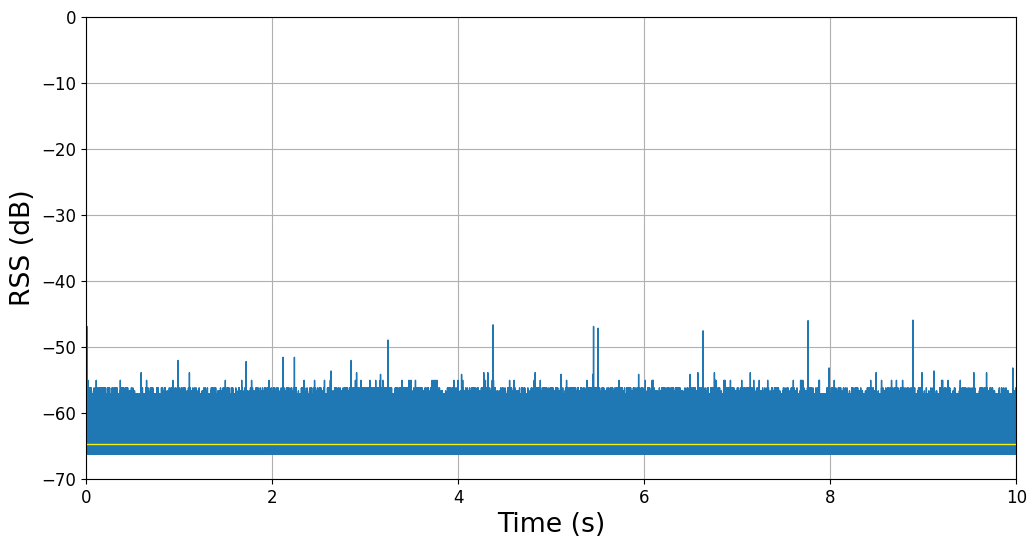

<Figure size 640x480 with 0 Axes>

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plot(ax, [noise['time']], [noise['rss']], x_label='Time (s)', y_label='RSS (dB)', x_lim=[0, 10], y_lim=[-70, 0], linewidth=1, axhline=[noise_floor], fontsize=24)
fig.savefig('figures/noise.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

In [37]:
raw_data = read_binary_iq_samples('datasets/drone2_second_1m/113_degrees')
raw_data = fill_iq_with_rss(raw_data, time_window=time_window, noise_floor=noise_floor)
data = extract_packets(raw_data, noise_floor=raw_data['rss'].quantile(.6), window=10000)
data_mean = data['rss'].mean()
data_median = data['rss'].median()

data = data[data['time'] >= 1]

values = []
quantiles = []
for i in tqdm(range(1, 100, 5)):
    quantile = float(i) / 100
    quantiles.append(quantile)
    values.append(data['rss'].quantile(quantile))

print(f'Mean: {data_mean} ~ Median: {data_median}')
data_floor = data_mean

100%|██████████| 20/20 [00:00<00:00, 56.60it/s]

Mean: -45.74161638785014 ~ Median: -45.36273567105737


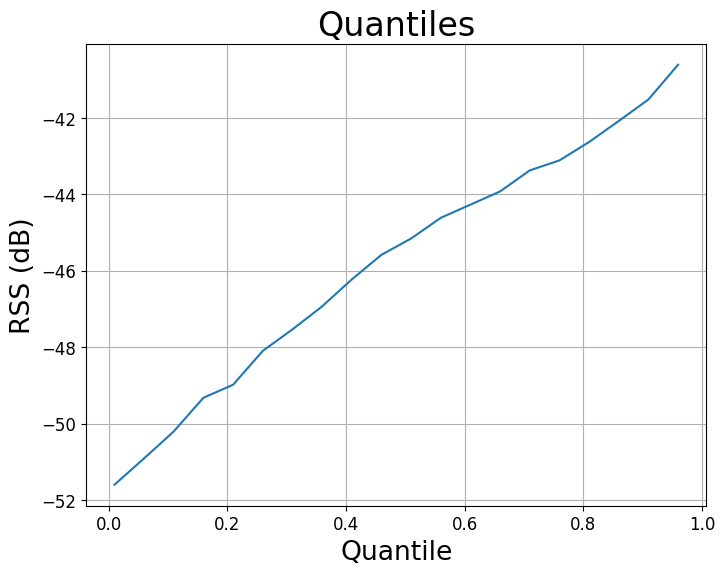

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plot(ax, [quantiles], [values], title='Quantiles', x_label='Quantile', y_label='RSS (dB)', fontsize=24)

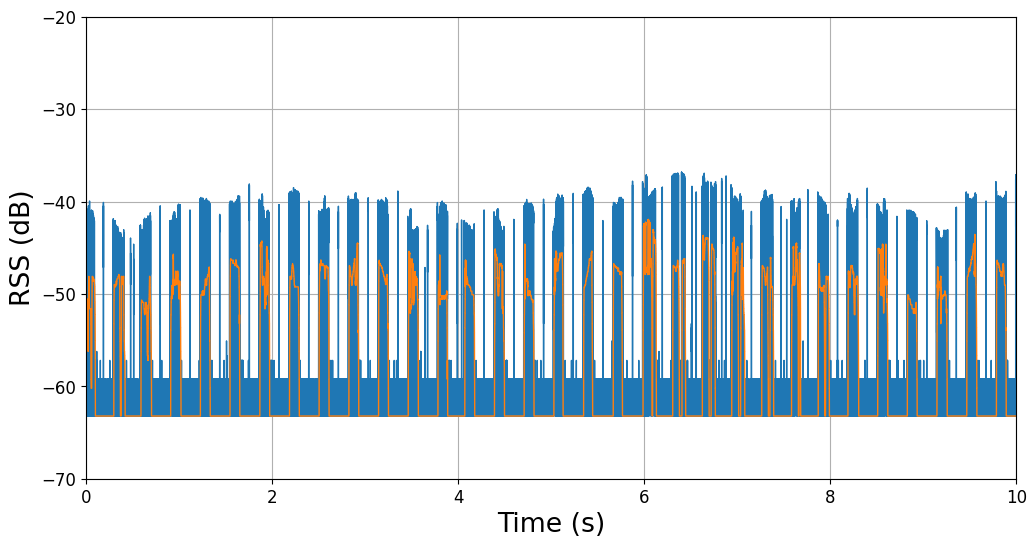

<Figure size 640x480 with 0 Axes>

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plot(ax, [raw_data['time'], raw_data['time']], [raw_data['rss'], raw_data['rolling_rss']], x_label='Time (s)', y_label='RSS (dB)', x_lim=[0, 10], y_lim=[-70, -20], linewidth=1, fontsize=24)
fig.savefig('figures/rolling_median.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

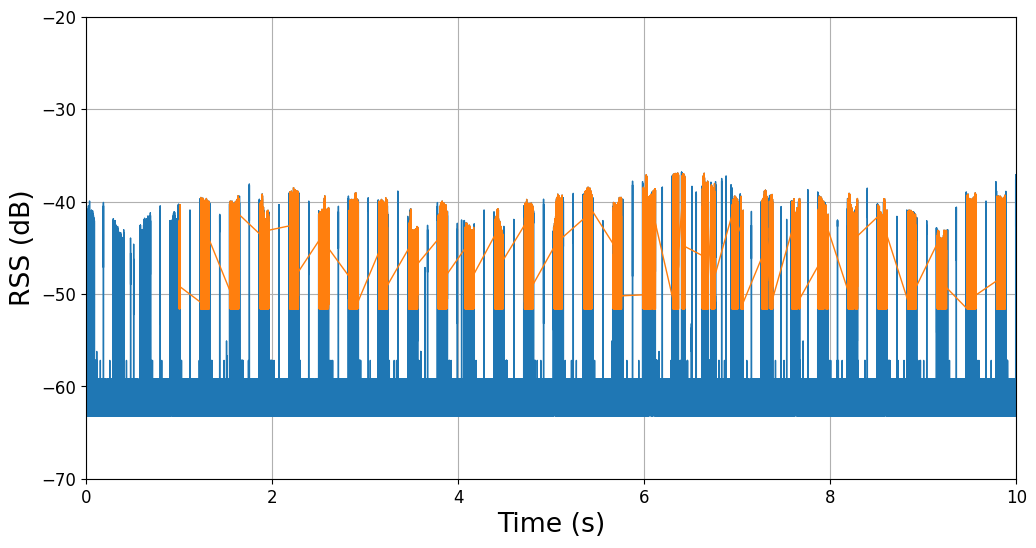

<Figure size 640x480 with 0 Axes>

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plot(ax, [raw_data['time'], data['time']], [raw_data['rss'], data['rss']], x_label='Time (s)', y_label='RSS (dB)', x_lim=[0, 10], y_lim=[-70, -20], linewidth=1, fontsize=24)
fig.savefig('figures/rss_of_drone.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

# Drone 1 Blocks

In [41]:
radiation_patterns = []

directory = 'datasets/drone1_1m/'  # Replace with the actual directory path
angle_measurements_drone1 = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        data = extract_packets(data, noise_floor=data['rss'].quantile(.6), window=10000)
        
        data = data[data['time'] >= 1]
        data = data.reset_index()
        data['time_diff'] = data['time'].diff()

        previous_start = 0
        blocks = []
        for i, item in data[data['time_diff'] > .1].iterrows():
            blocks.append(data.iloc[previous_start:i-1])
            previous_start = i

        angle_measurements_drone1[degrees] = blocks
        

100%|██████████| 16/16 [02:29<00:00,  9.32s/it]


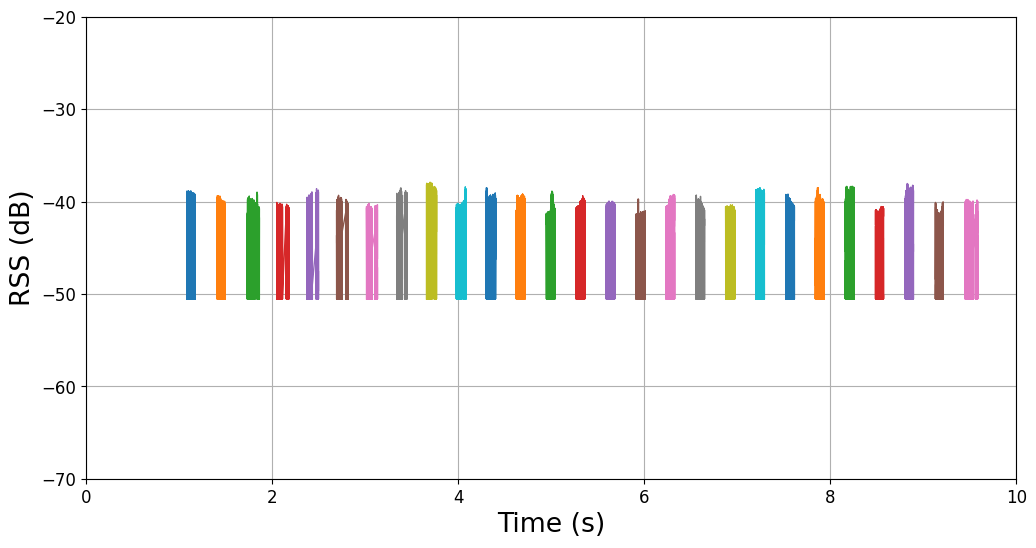

<Figure size 640x480 with 0 Axes>

In [52]:
x_axis = []
y_axis = []
for packet in angle_measurements_drone1[0]:
    # color = (random.random(), random.random(), random.random())
    x_axis.append(packet['time'])
    y_axis.append(packet['rss'])
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plot(ax, x_axis=x_axis, y_axis=y_axis, x_label='Time (s)', y_label='RSS (dB)', x_lim=[0, 10], y_lim=[-70, -20], linewidth=1, fontsize=24)
fig.savefig('figures/isolated_peaks_drone.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

In [53]:
radiation_patterns = []

directory = 'datasets/drone1_second_1m/'  # Replace with the actual directory path
angle_measurements_drone1_1 = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        data = extract_packets(data, noise_floor=data['rss'].quantile(.6), window=10000)
        
        data = data[data['time'] >= 1]
        data = data.reset_index()
        data['time_diff'] = data['time'].diff()

        previous_start = 0
        blocks = []
        for i, item in data[data['time_diff'] > .1].iterrows():
            blocks.append(data.iloc[previous_start:i-1])
            previous_start = i

        angle_measurements_drone1_1[degrees] = blocks
        

100%|██████████| 16/16 [02:32<00:00,  9.55s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


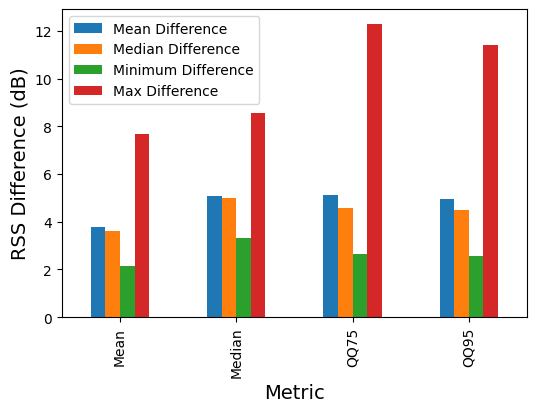

In [54]:
result_array = []
result = {}
for key, value in angle_measurements_drone1.items():
    means = [d['rss'].mean() for d in value]
    result[key] = max(means) - min(means)
    result_array.append(result)

result_array.append({'mean_difference': statistics.mean(result.values()), 'median_difference': statistics.median(result.values()), 'min_value': min(result.values()), 'max_value': max(result.values()), 'metric': 'Mean'})

result = {}
for key, value in angle_measurements_drone1.items():
    means = [d['rss'].median() for d in value]
    result[key] = max(means) - min(means)
    result_array.append(result)

result_array.append({'mean_difference': statistics.mean(result.values()), 'median_difference': statistics.median(result.values()), 'min_value': min(result.values()), 'max_value': max(result.values()), 'metric': 'Median'})

result = {}
for key, value in angle_measurements_drone1.items():
    means = [d['rss'].quantile(.75) for d in value]
    result[key] = max(means) - min(means)
    result_array.append(result)

result_array.append({'mean_difference': statistics.mean(result.values()), 'median_difference': statistics.median(result.values()), 'min_value': min(result.values()), 'max_value': max(result.values()), 'metric': 'QQ75'})

result = {}
for key, value in angle_measurements_drone1.items():
    means = [d['rss'].quantile(.95) for d in value]
    result[key] = max(means) - min(means)
    result_array.append(result)

result_array.append({'mean_difference': statistics.mean(result.values()), 'median_difference': statistics.median(result.values()), 'min_value': min(result.values()), 'max_value': max(result.values()), 'metric': 'QQ95'})

df = pd.DataFrame(result_array)
pivot_table = df.pivot_table(index='metric', values=['mean_difference', 'median_difference', 'min_value', 'max_value']).reindex(['mean_difference', 'median_difference', 'min_value', 'max_value'], axis=1)
pivot_table.columns = ['Mean Difference', 'Median Difference', 'Minimum Difference', 'Max Difference']
pivot_table = pivot_table.rename_axis(['Metric'])

fig, ax = plt.subplots(figsize=(6, 4))
pivot_table.plot(ax=ax, kind='bar')

# Set the plot labels and title
# ax.set_title('Characteristics of different metrics', fontsize=20)
ax.set_xlabel('Metric', fontsize=20*.7)
ax.set_ylabel('RSS Difference (dB)', fontsize=20*.7)
ax.tick_params(axis='x', labelsize=20*.5)  # Set x-axis tick label font size
ax.tick_params(axis='y', labelsize=20*.5)  # Set y-axis tick label font size

fig.savefig('figures/characteristics_of_different_metrics.eps', format='eps')
# fig.clf()
# plt.close(fig=fig)
# plt.clf()


In [55]:
result = {}
for key, value in angle_measurements_drone1_1.items():
    means = [d['rss'].mean() for d in value]
    result[key] = max(means) - min(means)
# Compute the mean, median, minimum, and maximum values
mean_value = statistics.mean(result.values())
median_value = statistics.median(result.values())
min_value = min(result.values())
max_value = max(result.values())

# Print the results
print("Mean:", mean_value)
print("Median:", median_value)
print("Minimum:", min_value)
print("Maximum:", max_value)

Mean: 4.65200498633679
Median: 3.552862830459592
Minimum: 2.506834931394785
Maximum: 9.553514368446194


In [56]:
rad_pat_1 = reverse_arrays_to_dicts(angle_measurements_drone1)
rad_pat_1_1 = reverse_arrays_to_dicts(angle_measurements_drone1_1)

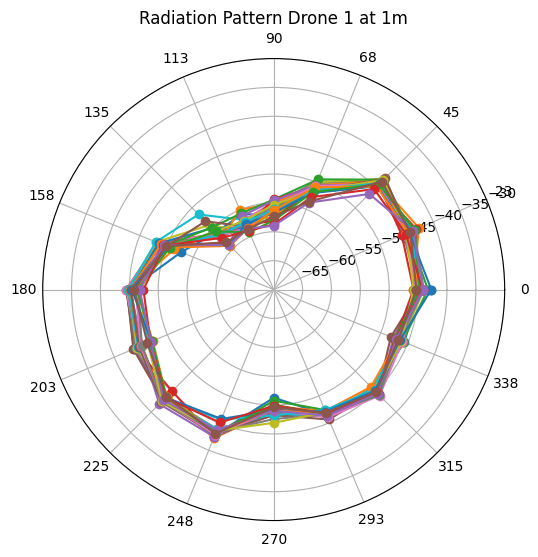

<Figure size 640x480 with 0 Axes>

In [57]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw={'projection': 'polar'})

for rp in rad_pat_1:
    # print(rp)
    create_radiation_pattern(axis, rp, y_limit=(-70, -30), title='Radiation Pattern Drone 1 at 1m')
plt.show()
fig.savefig('figures/radiation_pattern_differences_1_measurement.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

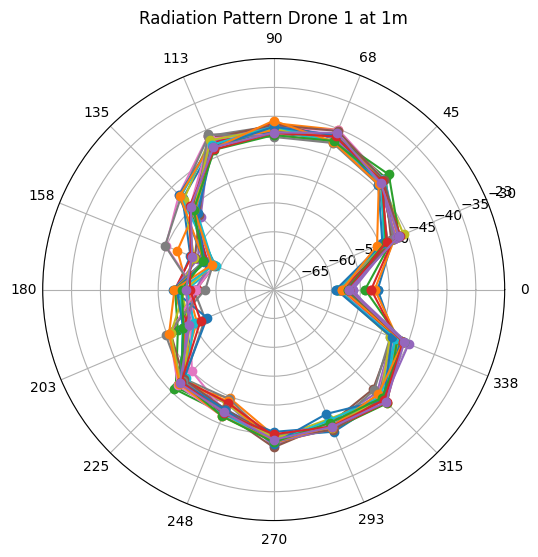

<Figure size 640x480 with 0 Axes>

In [58]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw={'projection': 'polar'})

for rp in rad_pat_1_1:
    # print(rp)
    create_radiation_pattern(axis, rp, y_limit=(-70, -30), title='Radiation Pattern Drone 1 at 1m')
plt.show()
fig.savefig('figures/radiation_pattern_differences_1_measurement.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

# Drone 2 Blocks

In [59]:
radiation_patterns = []

directory = 'datasets/drone2_second_1m/'  # Replace with the actual directory path
angle_measurements_drone2 = {}
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = read_binary_iq_samples(directory + filename)
        data = fill_iq_with_rss(data, time_window=time_window, noise_floor=noise_floor)
        data = extract_packets(data, noise_floor=data['rss'].quantile(.6), window=10000)
        
        data = data[data['time'] >= 1]
        data = data.reset_index()
        data['time_diff'] = data['time'].diff()

        previous_start = 0
        blocks = []
        for i, item in data[data['time_diff'] > .1].iterrows():
            blocks.append(data.iloc[previous_start:i-1])
            previous_start = i

        angle_measurements_drone2[degrees] = blocks
        

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [02:36<00:00,  9.77s/it]


In [60]:
result = {}
for key, value in angle_measurements_drone2.items():
    means = [d['rss'].mean() for d in value]
    result[key] = max(means) - min(means)
# Compute the mean, median, minimum, and maximum values
mean_value = statistics.mean(result.values())
median_value = statistics.median(result.values())
min_value = min(result.values())
max_value = max(result.values())

# Print the results
print("Mean:", mean_value)
print("Median:", median_value)
print("Minimum:", min_value)
print("Maximum:", max_value)

Mean: 4.7263422971643525
Median: 4.493908613466175
Minimum: 2.7639404298231014
Maximum: 7.8081559206509255


In [61]:
rad_pat_2 = reverse_arrays_to_dicts(angle_measurements_drone2)

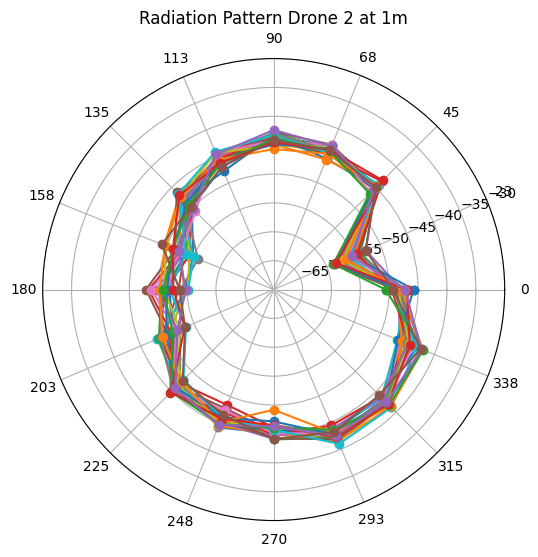

<Figure size 640x480 with 0 Axes>

In [62]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw={'projection': 'polar'})

for rp in rad_pat_2:
    # print(rp)
    create_radiation_pattern(axis, rp, y_limit=(-70, -30), title='Radiation Pattern Drone 2 at 1m')
plt.show()
fig.savefig('figures/radiation_pattern_differences_2_measurement.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

# Distances


In [63]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import dice
from sklearn.cluster import KMeans

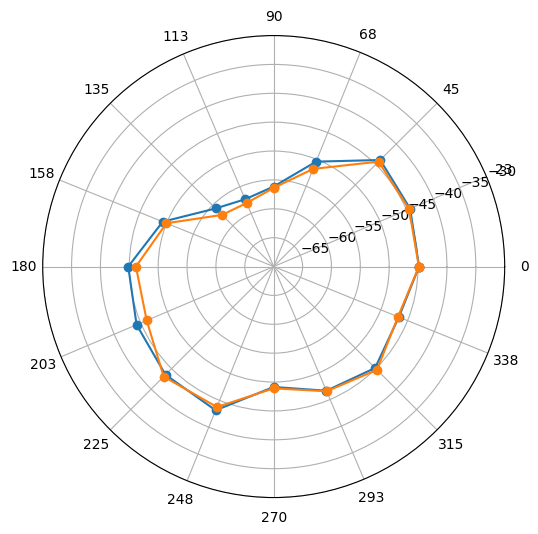

<Figure size 640x480 with 0 Axes>

In [77]:
rad_pat_1_merged = []
# Iterate over the dictionaries in parallel using zip
size = 13
for i in range(2):
    mean_values = {}
    for key in rad_pat_1[0]:
        values = [d[key] for d in rad_pat_1[i*size:i*size+size]]
        mean_values[key] = statistics.mean(values)
    rad_pat_1_merged.append(mean_values)

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw={'projection': 'polar'})

for rp in rad_pat_1_merged:
    # print(rp)
    create_radiation_pattern(axis, rp, y_limit=(-70, -30))
plt.show()
fig.savefig('figures/radiation_pattern_2_halves.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

In [74]:
rad_pat_1_merged = []
# Iterate over the dictionaries in parallel using zip
size = 5
for i in range(5):
    mean_values = {}
    for key in rad_pat_1[0]:
        values = [d[key] for d in rad_pat_1[i*size:i*size+size]]
        mean_values[key] = statistics.mean(values)
    rad_pat_1_merged.append(mean_values)

In [65]:
rad_pat_1_1_merged = []
# Iterate over the dictionaries in parallel using zip
for i in range(5):
    mean_values = {}
    for key in rad_pat_1_1[0]:
        values = [d[key] for d in rad_pat_1_1[i*5:i*5+5]]
        mean_values[key] = statistics.mean(values)
    rad_pat_1_1_merged.append(mean_values)

In [66]:
rad_pat_2_merged = []
# Iterate over the dictionaries in parallel using zip
for i in range(5):
    mean_values = {}
    for key in rad_pat_2[0]:
        values = [d[key] for d in rad_pat_2[i*5:i*5+5]]
        mean_values[key] = statistics.mean(values)
    rad_pat_2_merged.append(mean_values)

In [183]:
v = DictVectorizer(sparse=False)
X1 = v.fit_transform(rad_pat_1_merged)
X1_1 = v.fit_transform(rad_pat_1_1_merged)
X2 = v.fit_transform(rad_pat_2_merged)
X12 = v.fit_transform(rad_pat_1_merged + rad_pat_2_merged)
X11_1 = v.fit_transform(rad_pat_1_merged + rad_pat_1_1_merged)
X1_12 = v.fit_transform(rad_pat_1_1_merged + rad_pat_2_merged)

In [184]:
similarities = cosine_similarity(X1)

indices = [f'Drone 1.{i+1}' for i in range(len(rad_pat_1_merged))]
df = pd.DataFrame(similarities, columns=indices)
df.index = indices
df_styled = df.style.background_gradient(cmap='Greens', vmin=.98, vmax=1).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')
df_styled

,Drone 1.1,Drone 1.2,Drone 1.3,Drone 1.4,Drone 1.5
Drone 1.1,1.0000,0.9998,0.9998,0.9998,0.9998
Drone 1.2,0.9998,1.0000,0.9999,0.9999,0.9997
Drone 1.3,0.9998,0.9999,1.0000,0.9999,0.9998
Drone 1.4,0.9998,0.9999,0.9999,1.0000,0.9999
Drone 1.5,0.9998,0.9997,0.9998,0.9999,1.0000


In [185]:
similarities = cosine_similarity(X1_1)

indices = [f'Drone 1.{i+1}' for i in range(len(rad_pat_1_1_merged))]
df = pd.DataFrame(similarities, columns=indices)
df.index = indices
df_styled = df.style.background_gradient(cmap='Greens', vmin=.98, vmax=1).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')
df_styled

,Drone 1.1,Drone 1.2,Drone 1.3,Drone 1.4,Drone 1.5
Drone 1.1,1.0000,0.9995,0.9996,0.9992,0.9997
Drone 1.2,0.9995,1.0000,0.9997,0.9993,0.9996
Drone 1.3,0.9996,0.9997,1.0000,0.9997,0.9998
Drone 1.4,0.9992,0.9993,0.9997,1.0000,0.9997
Drone 1.5,0.9997,0.9996,0.9998,0.9997,1.0000


In [186]:
similarities = cosine_similarity(X2)

indices = [f'Drone 1.{i+1}' for i in range(len(rad_pat_2_merged))]
df = pd.DataFrame(similarities, columns=indices)
df.index = indices
df_styled = df.style.background_gradient(cmap='Greens', vmin=.98, vmax=1).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')
df_styled

,Drone 1.1,Drone 1.2,Drone 1.3,Drone 1.4,Drone 1.5
Drone 1.1,1.0000,0.9999,0.9999,0.9997,0.9996
Drone 1.2,0.9999,1.0000,0.9998,0.9997,0.9996
Drone 1.3,0.9999,0.9998,1.0000,0.9999,0.9997
Drone 1.4,0.9997,0.9997,0.9999,1.0000,0.9998
Drone 1.5,0.9996,0.9996,0.9997,0.9998,1.0000


In [187]:
similarities = cosine_similarity(X12)

indices = [f'Drone {(i//(len(rad_pat_1_merged + rad_pat_2_merged)//2))+1}.{i%5+1}' for i in range(len(rad_pat_1_merged + rad_pat_2_merged))]
df = pd.DataFrame(similarities, columns=indices)
df.index = indices
df_styled = df.style.background_gradient(cmap='Greens', vmin=.98, vmax=1).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')
df_styled

,Drone 1.1,Drone 1.2,Drone 1.3,Drone 1.4,Drone 1.5,Drone 2.1,Drone 2.2,Drone 2.3,Drone 2.4,Drone 2.5
Drone 1.1,1.0000,0.9998,0.9998,0.9998,0.9998,0.9904,0.9892,0.9907,0.9896,0.9897
Drone 1.2,0.9998,1.0000,0.9999,0.9999,0.9997,0.9912,0.9900,0.9915,0.9904,0.9905
Drone 1.3,0.9998,0.9999,1.0000,0.9999,0.9998,0.9917,0.9905,0.9920,0.9909,0.9910
Drone 1.4,0.9998,0.9999,0.9999,1.0000,0.9999,0.9916,0.9905,0.9920,0.9908,0.9909
Drone 1.5,0.9998,0.9997,0.9998,0.9999,1.0000,0.9905,0.9893,0.9909,0.9897,0.9899
Drone 2.1,0.9904,0.9912,0.9917,0.9916,0.9905,1.0000,0.9999,0.9999,0.9997,0.9996
Drone 2.2,0.9892,0.9900,0.9905,0.9905,0.9893,0.9999,1.0000,0.9998,0.9997,0.9996
Drone 2.3,0.9907,0.9915,0.9920,0.9920,0.9909,0.9999,0.9998,1.0000,0.9999,0.9997
Drone 2.4,0.9896,0.9904,0.9909,0.9908,0.9897,0.9997,0.9997,0.9999,1.0000,0.9998
Drone 2.5,0.9897,0.9905,0.9910,0.9909,0.9899,0.9996,0.9996,0.9997,0.9998,1.0000


In [188]:
similarities = cosine_similarity(X11_1)

indices = [f'Drone {(i//(len(rad_pat_1_merged + rad_pat_1_1_merged)//2))+1}.{i%5+1}' for i in range(len(rad_pat_1_merged + rad_pat_1_1_merged))]
df = pd.DataFrame(similarities, columns=indices)
df.index = indices
df_styled = df.style.background_gradient(cmap='Greens', vmin=.98, vmax=1).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')
df_styled

,Drone 1.1,Drone 1.2,Drone 1.3,Drone 1.4,Drone 1.5,Drone 2.1,Drone 2.2,Drone 2.3,Drone 2.4,Drone 2.5
Drone 1.1,1.0000,0.9998,0.9998,0.9998,0.9998,0.9871,0.9845,0.9850,0.9853,0.9864
Drone 1.2,0.9998,1.0000,0.9999,0.9999,0.9997,0.9876,0.9852,0.9854,0.9856,0.9869
Drone 1.3,0.9998,0.9999,1.0000,0.9999,0.9998,0.9885,0.9860,0.9864,0.9867,0.9879
Drone 1.4,0.9998,0.9999,0.9999,1.0000,0.9999,0.9885,0.9861,0.9865,0.9866,0.9879
Drone 1.5,0.9998,0.9997,0.9998,0.9999,1.0000,0.9873,0.9845,0.9849,0.9850,0.9864
Drone 2.1,0.9871,0.9876,0.9885,0.9885,0.9873,1.0000,0.9995,0.9996,0.9992,0.9997
Drone 2.2,0.9845,0.9852,0.9860,0.9861,0.9845,0.9995,1.0000,0.9997,0.9993,0.9996
Drone 2.3,0.9850,0.9854,0.9864,0.9865,0.9849,0.9996,0.9997,1.0000,0.9997,0.9998
Drone 2.4,0.9853,0.9856,0.9867,0.9866,0.9850,0.9992,0.9993,0.9997,1.0000,0.9997
Drone 2.5,0.9864,0.9869,0.9879,0.9879,0.9864,0.9997,0.9996,0.9998,0.9997,1.0000


In [192]:
similarities = cosine_similarity(X1_12)

indices = [f'Drone {(i//(len(rad_pat_1_1_merged + rad_pat_2_merged)//2))+1}.{i%5+1}' for i in range(len(rad_pat_1_1_merged + rad_pat_2_merged))]
df = pd.DataFrame(similarities, columns=indices)
df.index = indices
df_styled = df.style.background_gradient(cmap='Greens', vmin=.98, vmax=1).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')
df_styled

,Drone 1.1,Drone 1.2,Drone 1.3,Drone 1.4,Drone 1.5,Drone 2.1,Drone 2.2,Drone 2.3,Drone 2.4,Drone 2.5
Drone 1.1,1.0000,0.9995,0.9996,0.9992,0.9997,0.9978,0.9976,0.9976,0.9974,0.9969
Drone 1.2,0.9995,1.0000,0.9997,0.9993,0.9996,0.9963,0.9962,0.9962,0.9960,0.9954
Drone 1.3,0.9996,0.9997,1.0000,0.9997,0.9998,0.9966,0.9964,0.9963,0.9961,0.9955
Drone 1.4,0.9992,0.9993,0.9997,1.0000,0.9997,0.9969,0.9967,0.9965,0.9962,0.9956
Drone 1.5,0.9997,0.9996,0.9998,0.9997,1.0000,0.9975,0.9973,0.9974,0.9972,0.9967
Drone 2.1,0.9978,0.9963,0.9966,0.9969,0.9975,1.0000,0.9999,0.9999,0.9997,0.9996
Drone 2.2,0.9976,0.9962,0.9964,0.9967,0.9973,0.9999,1.0000,0.9998,0.9997,0.9996
Drone 2.3,0.9976,0.9962,0.9963,0.9965,0.9974,0.9999,0.9998,1.0000,0.9999,0.9997
Drone 2.4,0.9974,0.9960,0.9961,0.9962,0.9972,0.9997,0.9997,0.9999,1.0000,0.9998
Drone 2.5,0.9969,0.9954,0.9955,0.9956,0.9967,0.9996,0.9996,0.9997,0.9998,1.0000


We have a dataframe with RSS and time values, we now want to split this in multiple dataframes that each contain a part of the dataframe. The original dataframes consists of blocks in time, if the time between items is greater than .05 you can say it is a new block.

# The main measurements

In [42]:
directory = 'datasets/drone1_1m/'  # Replace with the actual directory path
drone1_1m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [02:04<00:00,  7.75s/it]


In [43]:
directory = 'datasets/drone2_1m/'  # Replace with the actual directory path
drone2_1m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [02:09<00:00,  8.11s/it]


In [44]:
directory = 'datasets/drone3_1m/'  # Replace with the actual directory path
drone3_1m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [01:58<00:00,  7.38s/it]


In [45]:
directory = 'datasets/drone1_second_1m/'  # Replace with the actual directory path
drone1_second_1m_measurement = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [02:06<00:00,  7.93s/it]


In [46]:
directory = 'datasets/drone2_second_1m/'  # Replace with the actual directory path
drone2_second_1m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [02:29<00:00,  9.32s/it]


In [47]:
directory = 'datasets/drone3_second_1m/'  # Replace with the actual directory path
drone3_second_1m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [02:24<00:00,  9.06s/it]


In [48]:
rss_values_radiation_patterns1 = [drone1_1m_measurements, drone2_1m_measurements, drone3_1m_measurements]
rss_values_radiation_patterns2 = [drone1_second_1m_measurement, drone2_second_1m_measurements, drone3_second_1m_measurements]

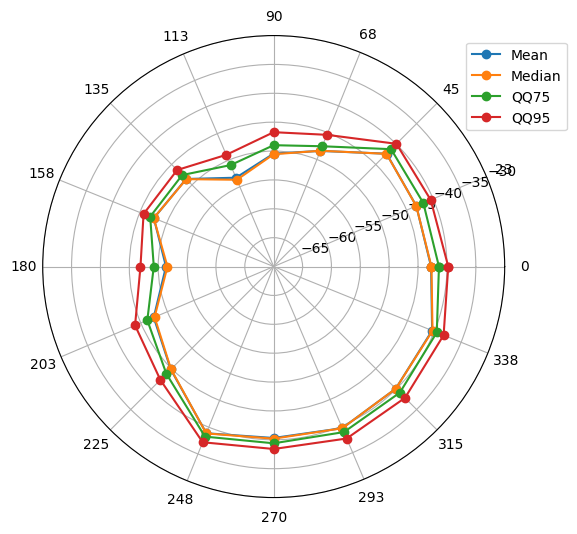

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

In [252]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw={'projection': 'polar'})

create_radiation_pattern_tuple(axis, rss_values_radiation_patterns1[1], y_limit=(-70, -30), id=[0, 1, 3, 5])
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

fig.savefig('figures/radiation_pattern_mean_median_qq75_qq95.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

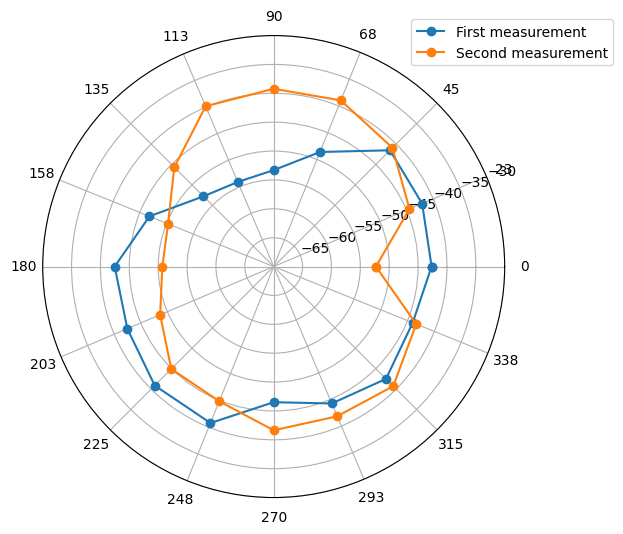

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

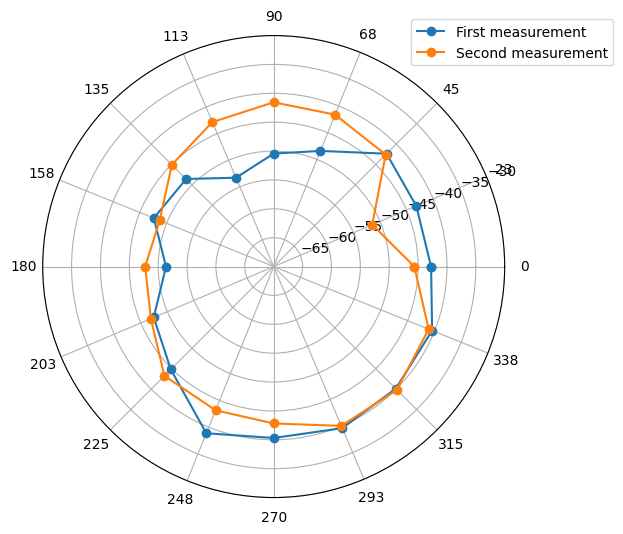

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

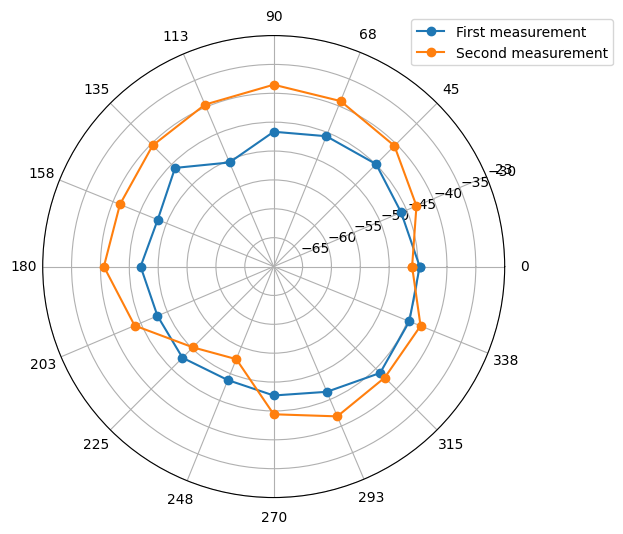

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

In [78]:
for i in range(len(rss_values_radiation_patterns1)):
    fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(7, 6), subplot_kw={'projection': 'polar'})
    create_radiation_pattern_tuple_label(axis, rss_values_radiation_patterns1[i], y_limit=(-70, -30), id=[0], label='First measurement')
    create_radiation_pattern_tuple_label(axis, rss_values_radiation_patterns2[i], y_limit=(-70, -30), id=[0], label='Second measurement')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
    plt.show()
    fig.savefig(f'figures/radiation_pattern_drones_first_second_{chr(i + 97)}.eps', format='eps')
    fig.clf()
    plt.close(fig=fig)
    plt.clf()

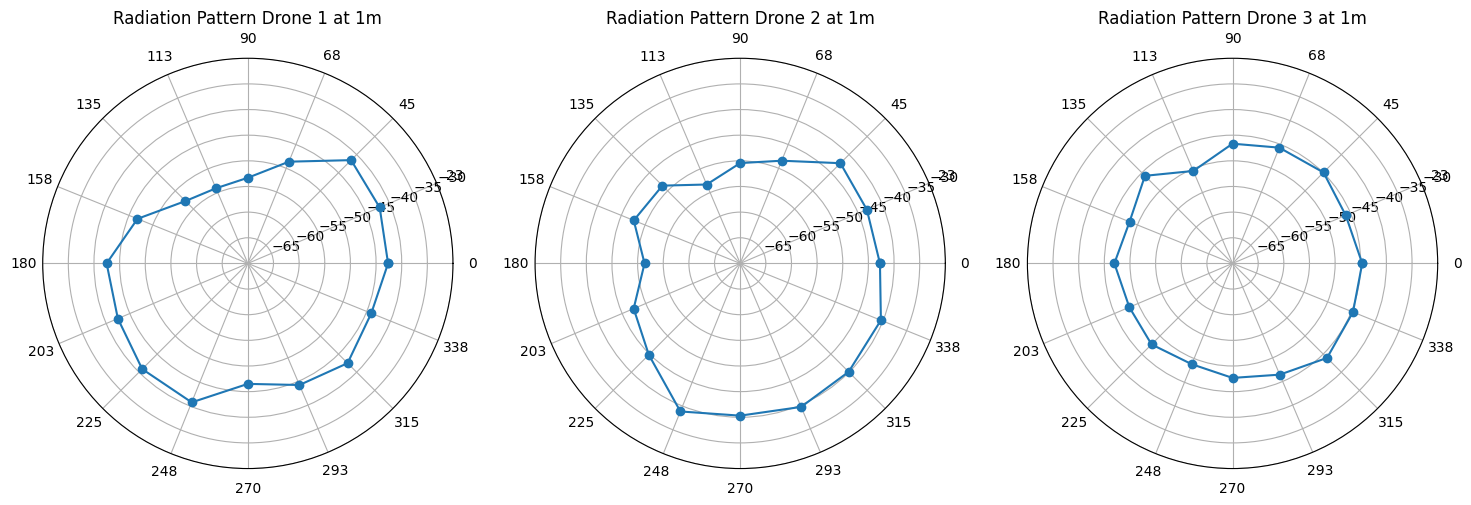

<Figure size 640x480 with 0 Axes>

In [196]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), subplot_kw={'projection': 'polar'})

for i in range(len(rss_values_radiation_patterns1)):
    create_radiation_pattern_tuple(axis[i], rss_values_radiation_patterns1[i], y_limit=(-70, -30), title=f'Radiation Pattern Drone {i+1} at 1m', id=[0])
    # create_radiation_pattern_tuple(axis[1, i], rss_values_radiation_patterns2[i], y_limit=(-70, -30), title=f'Radiation Pattern Drone {i+1} at 1m', id=[0, 1])
plt.show()
fig.savefig('figures/radiation_pattern_drones_first.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

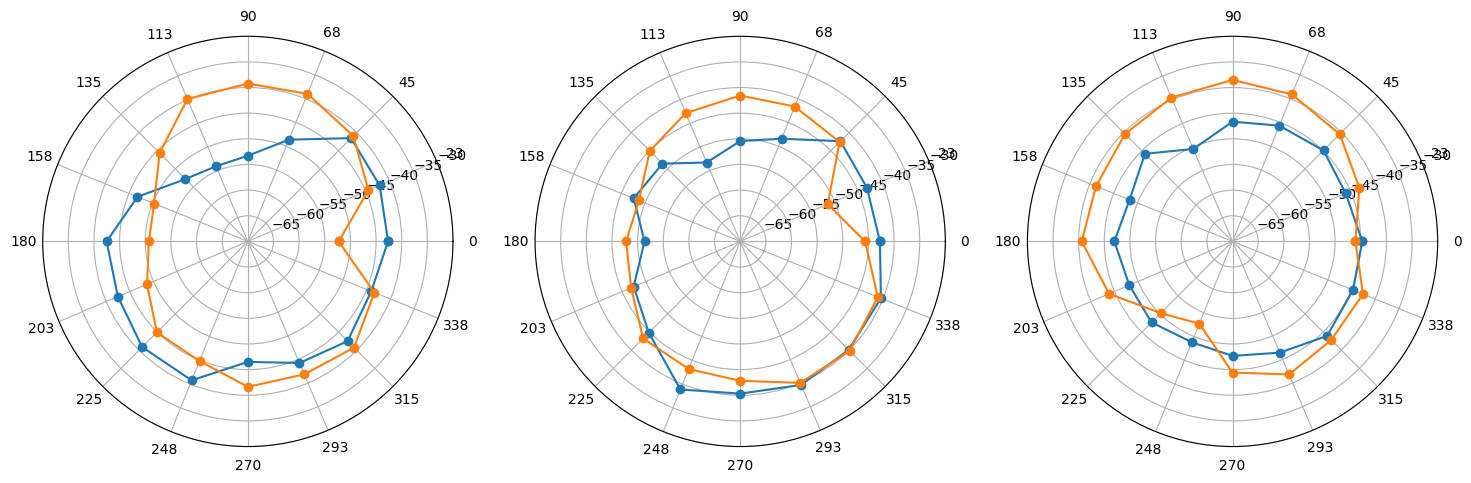

<Figure size 640x480 with 0 Axes>

In [235]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), subplot_kw={'projection': 'polar'})

for i in range(len(rss_values_radiation_patterns1)):
    create_radiation_pattern_tuple(axis[i], rss_values_radiation_patterns1[i], y_limit=(-70, -30), id=[0])
    create_radiation_pattern_tuple(axis[i], rss_values_radiation_patterns2[i], y_limit=(-70, -30), id=[0])
    
plt.show()
fig.savefig('figures/radiation_pattern_drones_first_second.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

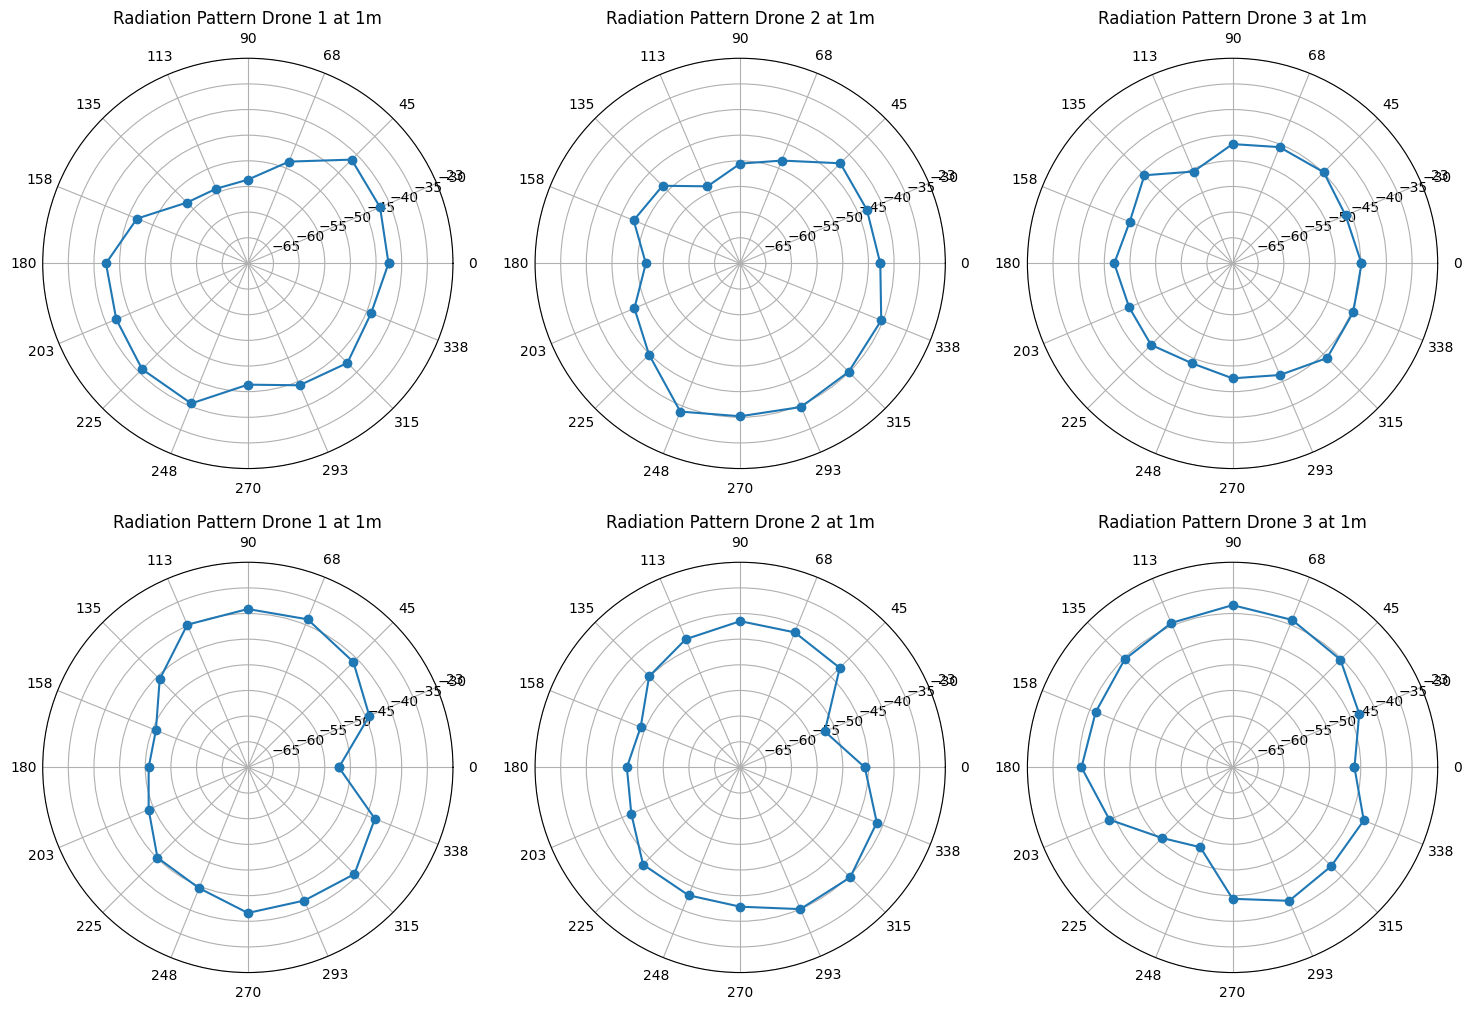

<Figure size 640x480 with 0 Axes>

In [81]:
fig, axis = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': 'polar'})

for i in range(len(rss_values_radiation_patterns1)):
    create_radiation_pattern_tuple(axis[0, i], rss_values_radiation_patterns1[i], y_limit=(-70, -30), title=f'Radiation Pattern Drone {i+1} at 1m', id=[1])
    create_radiation_pattern_tuple(axis[1, i], rss_values_radiation_patterns2[i], y_limit=(-70, -30), title=f'Radiation Pattern Drone {i+1} at 1m', id=[1])
plt.show()
fig.savefig('figures/radiation_pattern_drones_median.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

# Statistics

In [125]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import dice
from sklearn.cluster import KMeans

In [126]:
dicts = []
for i, dict in enumerate([drone1_1m_measurements, drone1_second_1m_measurement, drone2_1m_measurements, drone2_second_1m_measurements, drone3_1m_measurements, drone3_second_1m_measurements]):
    dicts.append(tuples_to_dicts(dict)[0])

v = DictVectorizer(sparse=False)
X = v.fit_transform(dicts)

In [192]:
import imgkit

similarities = cosine_similarity(X)

df = pd.DataFrame(similarities, columns=['Drone 1.1', 'Drone 1.2', 'Drone 2.1', 'Drone 2.2', 'Drone 3.1', 'Drone 3.2'])
df.index = ['Drone 1.1', 'Drone 1.2', 'Drone 2.1', 'Drone 2.2', 'Drone 3.1', 'Drone 3.2']
df_styled = df.style.background_gradient(cmap='Greens', vmin=min([min(x) for x in similarities]), vmax=1).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')


# Save styled DataFrame to HTML file
html_content = df_styled.to_html()
# Customize the CSS properties for background gradient
html_content_with_gradient = html_content.replace(
    '<style>',
    '<style>.dataframe td, .dataframe th {background: linear-gradient(to bottom, #FFFFFF, #CCE5FF);} '
)

df_width = len(df.columns) * 100  # Assuming each column has a width of 100 pixels

options = {
    'format': 'png',
    'encoding': 'utf-8',
    'quiet': '',
    'width': df_width, 
    'disable-smart-width': '',
}

imgkit.from_string(html_content_with_gradient, 'figures/cosine_similarity_all_drones.png', options=options)
df_styled

,Drone 1.1,Drone 1.2,Drone 2.1,Drone 2.2,Drone 3.1,Drone 3.2
Drone 1.1,1.0000,0.9875,0.9965,0.9915,0.9956,0.9861
Drone 1.2,0.9875,1.0000,0.9914,0.9977,0.9952,0.9943
Drone 2.1,0.9965,0.9914,1.0000,0.9945,0.9959,0.9863
Drone 2.2,0.9915,0.9977,0.9945,1.0000,0.9973,0.9938
Drone 3.1,0.9956,0.9952,0.9959,0.9973,1.0000,0.9961
Drone 3.2,0.9861,0.9943,0.9863,0.9938,0.9961,1.0000


In [99]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
labels = kmeans.labels_
print(labels)

[0 1 0 1 0 2]


/home/jos/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [262]:
num_dicts = len(dicts)

dice_distances = np.zeros((num_dicts, num_dicts))

for i in range(num_dicts):
    for j in range(i+1, num_dicts):
        distance = dice(X[i], X[j])
        dice_distances[i, j] = distance
        dice_distances[j, i] = distance

helper = np.array(dice_distances).flatten()
helper = helper[helper > 0]
print(min(helper))

custom_cmap = plt.cm.get_cmap('Greens').reversed()

df = pd.DataFrame(dice_distances, columns=['Drone 1.1', 'Drone 1.2', 'Drone 2.1', 'Drone 2.2', 'Drone 3.1', 'Drone 3.2'])
df.index = ['Drone 1.1', 'Drone 1.2', 'Drone 2.1', 'Drone 2.2', 'Drone 3.1', 'Drone 3.2']
df_styled = df.style.background_gradient(cmap=custom_cmap, vmin=min(helper), vmax=max(helper)).format("{:.4f}")
df_styled = df_styled.set_table_attributes('style="font-size: 14pt"')

# Save styled DataFrame to HTML file
html_content = df_styled.to_html()
# Customize the CSS properties for background gradient
html_content_with_gradient = html_content.replace(
    '<style>',
    '<style>.dataframe td, .dataframe th {background: linear-gradient(to bottom, #FFFFFF, #CCE5FF);} '
)

df_width = len(df.columns) * 100  # Assuming each column has a width of 100 pixels

options = {
    'format': 'png',
    'encoding': 'utf-8',
    'quiet': '',
    'width': df_width, 
    'disable-smart-width': '',
}

imgkit.from_string(html_content_with_gradient, 'figures/dice_dissimilarity_all_drones.png', options=options)

df_styled

44.49280892601105


/tmp/ipykernel_54042/4096700452.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_cmap = plt.cm.get_cmap('Greens').reversed()


,Drone 1.1,Drone 1.2,Drone 2.1,Drone 2.2,Drone 3.1,Drone 3.2
Drone 1.1,0.0000,45.6517,46.4421,45.6214,47.0520,44.8885
Drone 1.2,45.6517,0.0000,45.6499,45.3492,46.4535,44.7158
Drone 2.1,46.4421,45.6499,0.0000,45.5819,46.8750,44.7239
Drone 2.2,45.6214,45.3492,45.5819,0.0000,46.3342,44.4928
Drone 3.1,47.0520,46.4535,46.8750,46.3342,0.0000,45.7703
Drone 3.2,44.8885,44.7158,44.7239,44.4928,45.7703,0.0000


# Other

In [33]:
directory = 'datasets/drone1_1m/'  # Replace with the actual directory path
drone1_1m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [02:44<00:00, 10.25s/it]


In [49]:
directory = 'datasets/drone1_3m/'  # Replace with the actual directory path
drone1_3m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files:   0%|          | 0/16 [00:00<?, ?it/s]

Measurement files: 100%|██████████| 16/16 [01:50<00:00,  6.93s/it]


In [50]:
directory = 'datasets/drone1_5m/'  # Replace with the actual directory path
drone1_5m_measurements = get_drone_measurements(directory, time_window=time_window, noise_floor=noise_floor+2)

Measurement files: 100%|██████████| 16/16 [01:58<00:00,  7.44s/it]


In [51]:
rss_values_radiation_patterns_distances = [drone1_1m_measurements, drone1_3m_measurements, drone1_5m_measurements]

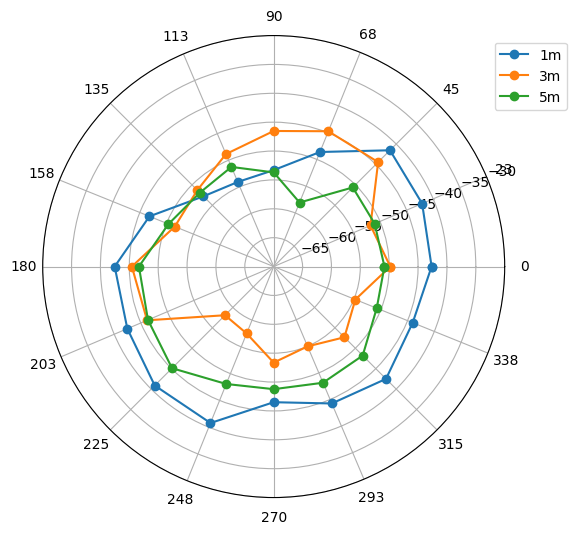

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

In [234]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw={'projection': 'polar'})
for i in range(len(rss_values_radiation_patterns1)):
    create_radiation_pattern_tuple_label(axis, rss_values_radiation_patterns_distances[i], y_limit=(-70, -30), id=[0], label=f'{i*2 + 1}m')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()
fig.savefig(f'figures/radiation_pattern_distances.eps', format='eps')
fig.clf()
plt.close(fig=fig)
plt.clf()

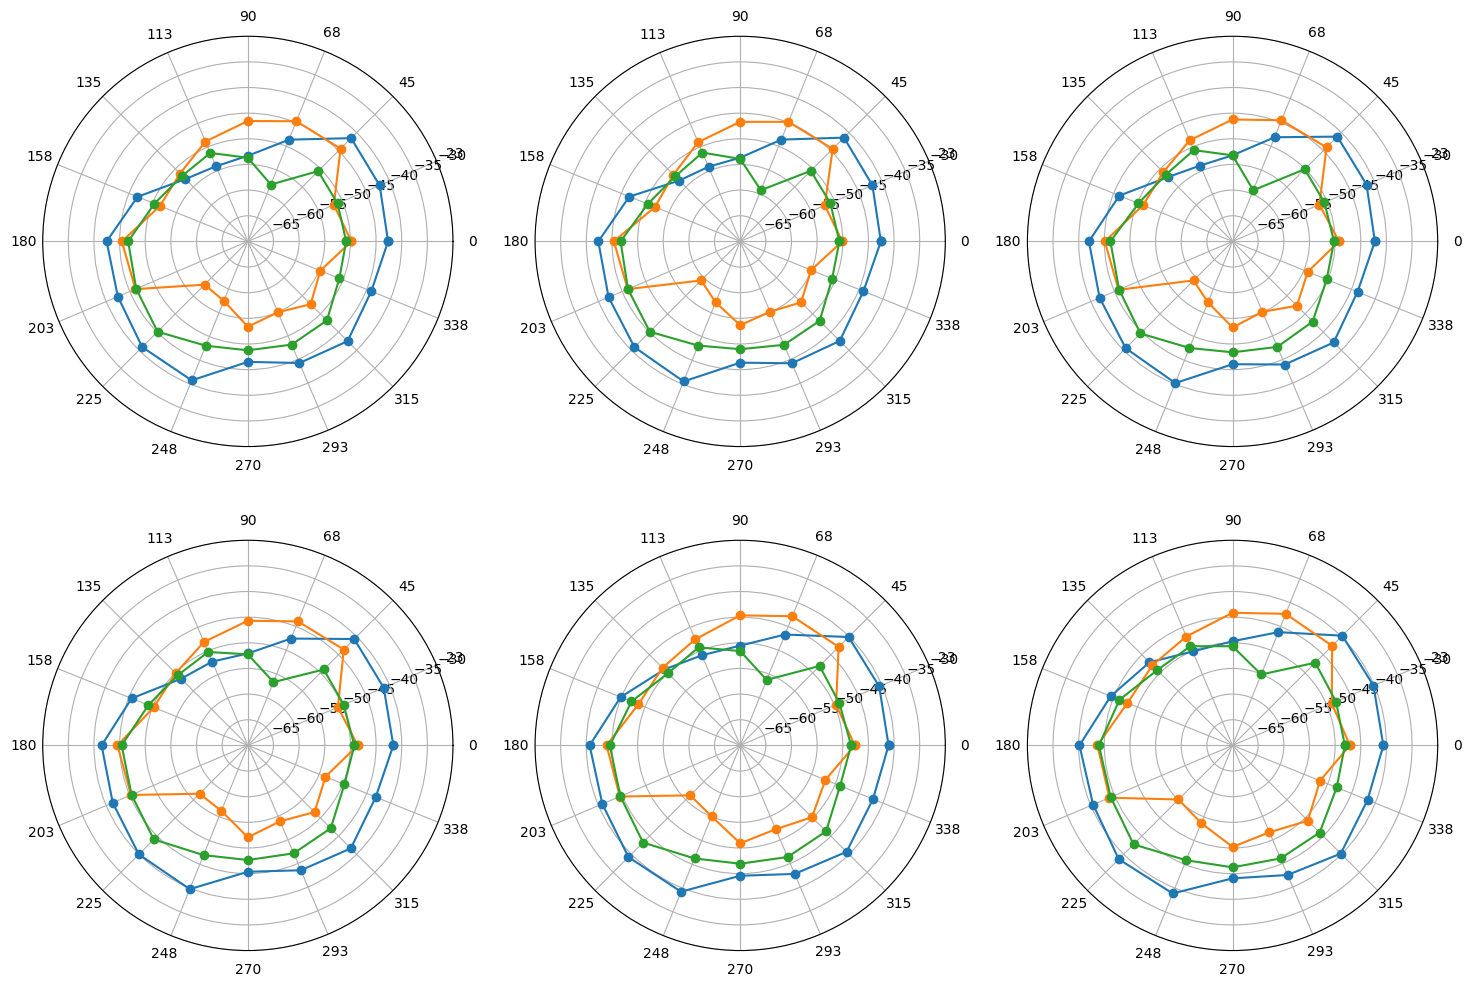

In [44]:
fig, axis = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': 'polar'})

for i in range(len(rss_values_radiation_patterns_distances)):
    for j, data in enumerate(tuples_to_dicts(rss_values_radiation_patterns_distances[i])):
        create_radiation_pattern(axis[j//3, j%3], data, y_limit=(-70, -30))
plt.show()